In [1]:
!pip install scanpy
!pip install KDEpy
!pip install leidenalg
!pip install scikit-misc

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


In [2]:
import pandas as pd
import scanpy as sc
import anndata as ad
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.sparse as sps
import re

import os
import sys
module_path = os.path.abspath(os.path.join('../..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
import tools.util_probe as up
import tools.util as ut
import tools.NB_est as nb
import tools.countsplit as cs
import tools.scDEED as scd
import tools.clustering_opt as co

import warnings
warnings.filterwarnings("ignore")

In [3]:
import importlib

## Preprocessing
### Read data

In [4]:
import gzip
import shutil
data_dir = "../../data/BacDrop/raw_data/"
file_names = ["GSM5456490_BIDMC35_align2_CDS.tsv"]

for f in file_names:
    file_name_full = data_dir + f

    if not f in os.listdir(data_dir):
        if f + ".gz" in os.listdir(data_dir):
            print("unzipping data...")
            with gzip.open(file_name_full + ".gz","rb") as f_in, open(file_name_full,"wb") as f_out:
                shutil.copyfileobj(f_in, f_out)
        else:
            raise FileNotFoundError(f"{f} does not exist in regular or zipped form")

In [5]:
adatas = []
for f in file_names:
    file_name_full = data_dir + f
    print(f)
    adata = sc.read_csv(file_name_full, delimiter="\t", first_column_names=True)
    adata = adata.transpose()
    adata.var_names_make_unique()
    adata.X = sps.csr_matrix(adata.X)
    adatas.append(adata)
    
adatas

GSM5456490_BIDMC35_align2_CDS.tsv


[AnnData object with n_obs × n_vars = 9936 × 4672]

In [6]:
data_untr = adatas[0]
data_untr

AnnData object with n_obs × n_vars = 9936 × 4672

In [7]:
print(f"Zero inflation of data: {((np.prod(data_untr.X.shape) - data_untr.X.getnnz()) / np.prod(data_untr.X.shape)).round(3)}")


Zero inflation of data: 0.99


### Filter cells

--> filter based on mean absolute standard deviation

In [8]:
importlib.reload(ut)
data_gene = data_untr.copy()
# sc.pp.filter_cells(data_gene, min_genes=15)
# sc.pp.filter_genes(data_gene, min_cells=2)
# sc.pp.calculate_qc_metrics(data_gene, var_type="genes", percent_top=None, log1p=True, inplace=True)

data_gene = ut.filter_outliers(data_untr, nmads=5, min_cells=2, min_genes=15)
# print(data_untr.obs.outlier.value_counts())
print(f"Total number of cells: {data_untr.n_obs}")
print(f"Number of cells after filtering: {data_gene.n_obs}")
data_gene

Total number of cells: 9936
Number of cells after filtering: 9168


AnnData object with n_obs × n_vars = 9168 × 4341
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'outlier', 'n_genes'
    var: 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'

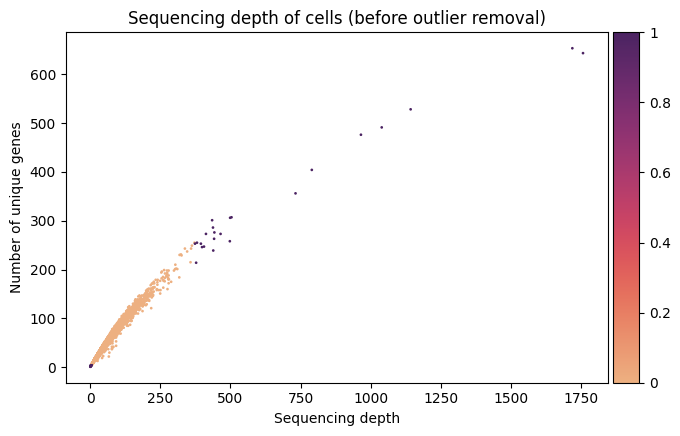

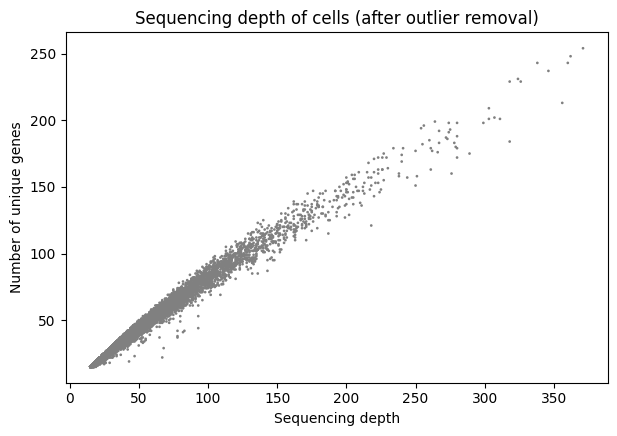

In [9]:
g = sc.pl.scatter(data_untr, x='total_counts', y='n_genes_by_counts', color="outlier", show=False, size=15, color_map="flare", title="Sequencing depth of cells (before outlier removal)")
g.set(xlabel = "Sequencing depth")
g.set(ylabel="Number of unique genes")
plt.tight_layout()
plt.show()

sc.pl.scatter(data_gene, x='total_counts', y='n_genes_by_counts', show=False, size=15)
plt.title("Sequencing depth of cells (after outlier removal)")
plt.xlabel("Sequencing depth")
plt.ylabel("Number of unique genes")
plt.show()

## Variance stabilization

Plotting the mean-variance ratio of genes, we see that the data is clearly overdispersed. Therefore, we will use negative binomial count splitting

In [10]:
data_gene.layers["counts"] = data_gene.X.copy()

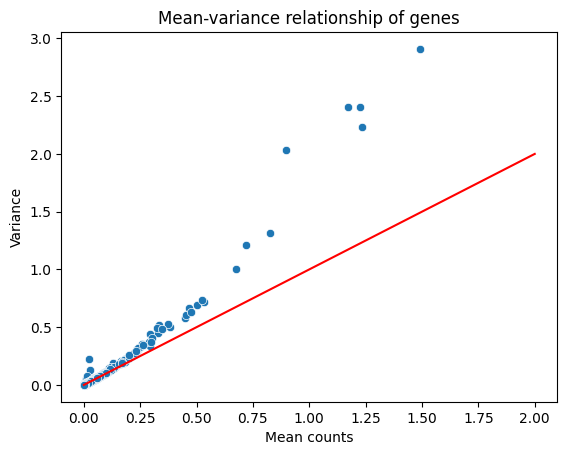

In [11]:
data_gene.var["var_counts"] = np.asarray(np.var(data_gene.X.toarray(), axis=0)).squeeze()
data_gene.var["mean_counts"] = np.asarray(np.mean(data_gene.X.toarray(), axis=0)).squeeze()
sns.scatterplot(data=data_gene.var, x="mean_counts", y="var_counts")
plt.plot([0, np.ceil(np.max(data_gene.var["mean_counts"]))], [0, np.ceil(np.max(data_gene.var["mean_counts"]))], color="red")
plt.title("Mean-variance relationship of genes")
plt.xlabel("Mean counts")
plt.ylabel("Variance")
plt.show()

In [12]:
mv_corr_lin = np.corrcoef(data_gene.var["mean_counts"], data_gene.var["var_counts"])[0,1]
mv_corr_sq = np.corrcoef(data_gene.var["mean_counts"]**2, data_gene.var["var_counts"])[0,1]

if mv_corr_sq > mv_corr_lin:
    is_overdispersed = True
else:
    is_overdispersed = False
    
print(is_overdispersed)

False


## Estimate negative binomial parameters for each gene

In [13]:
importlib.reload(nb)
nb.estimate_overdisp_nb(data_gene, layer="counts", flavor="sctransform", seed=1234)

In [14]:
data_gene.var

n_cells_by_counts  mean_counts  log1p_mean_counts  \
cds-OWG15607.1                 12     0.001309           0.001308   
cds-OWG15608.1                 22     0.002400           0.002397   
cds-OWG15609.1                  9     0.000982           0.000981   
cds-OWG15869.1                 15     0.001963           0.001961   
cds-OWG15870.1                  7     0.000873           0.000872   
...                           ...          ...                ...   
cds-OWG24215.1                 20     0.002182           0.002179   
cds-OWG24216.1                 61     0.006981           0.006957   
cds-OWG24217.1                 20     0.002182           0.002179   
cds-OWG24218.1                509     0.057919           0.056304   
cds-OWG24219.1                 19     0.002072           0.002070   

                pct_dropout_by_counts  total_counts  log1p_total_counts  \
cds-OWG15607.1              99.869110          12.0            2.564949   
cds-OWG15608.1              99.760035          22.0            3.135494   
cds-OWG15609.1              99.901832           9.0            2.302585   
cds-OWG15869.1              99.836387          18.0            2.944439   
cds-OWG15870.1              99.923647           8.0            2.197225   
...                               ...           ...                 ...   
cds-OWG24215.1              99.781850          20.0            3.044523   
cds-OWG24216.1              99.334642          64.0            4.174387   
cds-OWG24217.1              99.781850          20.0            3.044523   
cds-OWG24218.1              94.448080         531.0            6.276643   
cds-OWG24219.1              99.792757          19.0            2.995732   

                n_cells  var_counts  is_scd_outlier  nb_overdisp  \
cds-OWG15607.1       12    0.001307           False     0.054682   
cds-OWG15608.1       22    0.002394           False     0.032203   
cds-OWG15609.1        9    0.000981           False     0.045494   
cds-OWG15869.1       15    0.002614           False     0.022197   
cds-OWG15870.1        7    0.001090           False     0.004161   
...                 ...         ...             ...          ...   
cds-OWG24215.1       20    0.002176           False     0.062745   
cds-OWG24216.1       61    0.007587           False     0.221685   
cds-OWG24217.1       20    0.002177           False     0.062745   
cds-OWG24218.1      509    0.059365           False     1.375910   
cds-OWG24219.1       19    0.002068           False     0.059701   

                nb_overdisp_cutoff    nb_mean    nb_umi  Intercept_step1_sct  \
cds-OWG15607.1            0.054682 -11.175705  2.562950           -12.796834   
cds-OWG15608.1            0.032203 -10.142067  2.347428                  NaN   
cds-OWG15609.1            0.045494 -10.477695  2.014927           -13.963593   
cds-OWG15869.1            0.022197  -9.974717  2.098049            -7.651381   
cds-OWG15870.1            0.010000 -11.281941  2.421607                  NaN   
...                            ...        ...       ...                  ...   
cds-OWG24215.1            0.062745 -10.870089  2.679457           -11.316345   
cds-OWG24216.1            0.221685  -8.747035  2.160661                  NaN   
cds-OWG24217.1            0.062745 -10.870089  2.679457            -8.904459   
cds-OWG24218.1            1.375910  -6.785257  2.257903            -6.608294   
cds-OWG24219.1            0.059701 -10.067245  2.211670            -7.967578   

                log_umi_step1_sct  dispersion_step1_sct  
cds-OWG15607.1           3.446643              0.006611  
cds-OWG15608.1                NaN                   NaN  
cds-OWG15609.1           3.902217              0.004330  
cds-OWG15869.1           0.836572              0.101570  
cds-OWG15870.1                NaN                   NaN  
...                           ...                   ...  
cds-OWG24215.1           2.934446              0.006074  
cds-OWG24216.1                NaN           

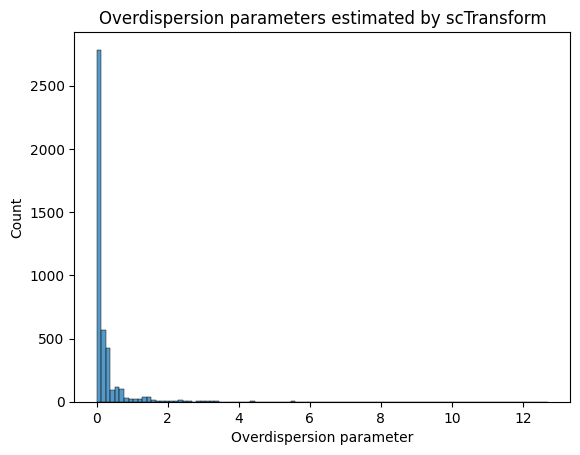

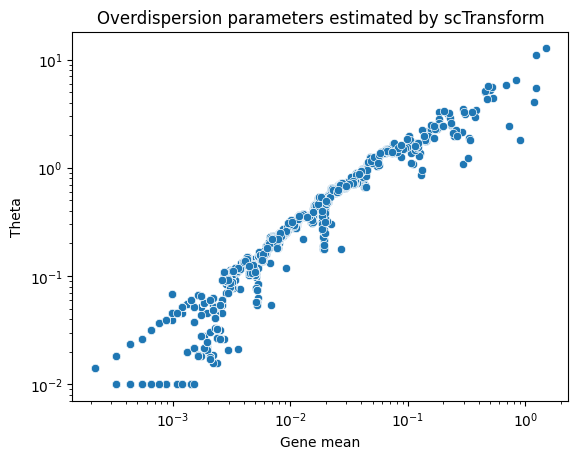

In [15]:
sns.histplot(data=data_gene.var, x="nb_overdisp_cutoff", bins=100)
plt.title("Overdispersion parameters estimated by scTransform")
plt.xlabel("Overdispersion parameter")
plt.show()

g = sns.scatterplot(data=data_gene.var, y="nb_overdisp_cutoff", x="mean_counts")
g.set(xscale="log", yscale="log")
plt.title("Overdispersion parameters estimated by scTransform")
plt.xlabel("Gene mean")
plt.ylabel("Theta")
plt.show()

In [16]:
data_gene.X = data_gene.layers["counts"].copy()

## Normalization, VST, scaling and PCA

In [17]:
sc.pp.normalize_total(data_gene, target_sum=None, layer=None)
if is_overdispersed:
    data_gene.X = sps.csr_matrix(np.log(data_gene.X.toarray() + np.array(data_gene.var["nb_overdisp_cutoff"] / 4)))
else:
    # data_gene.X = sps.csr_matrix(np.sqrt(data_gene.X.toarray()))
    data_gene.X = sps.csr_matrix(np.log(data_gene.X.toarray() + np.array(data_gene.var["nb_overdisp_cutoff"] / 4)))

data_gene.layers["vst_counts"] = data_gene.X.copy()
sc.pp.scale(data_gene, max_value=10, zero_center=True)
sc.pp.highly_variable_genes(data_gene, n_top_genes=2500, flavor="seurat_v3", layer="counts")
data_gene = data_gene[:, data_gene.var.highly_variable]
# data_gene.X[np.isnan(data_gene.X)] = 0
sc.tl.pca(data_gene, svd_solver='arpack')

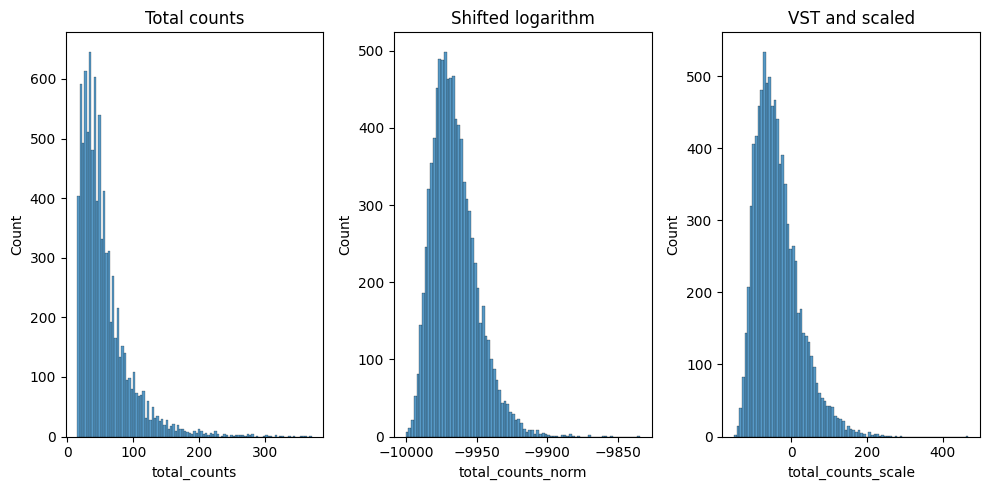

In [18]:
fig, axes = plt.subplots(1, 3, figsize=(10, 5))
p1 = sns.histplot(data_gene.obs, x="total_counts", kde=False, ax=axes[0], multiple="stack")
axes[0].set_title("Total counts")
data_gene.obs["total_counts_norm"] = data_gene.layers["vst_counts"].sum(1)
p2 = sns.histplot(data_gene.obs, x="total_counts_norm", kde=False, ax=axes[1], multiple="stack")
axes[1].set_title("Shifted logarithm")
data_gene.obs["total_counts_scale"] = data_gene.X.sum(1)
p2 = sns.histplot(data_gene.obs, x="total_counts_scale", kde=False, ax=axes[2], multiple="stack")
axes[2].set_title("VST and scaled")
plt.tight_layout()
plt.show()

## Count-splitting into train and test data

In [19]:
if is_overdispersed:
    data_dist = "NB"
else:
    data_dist = "Poi"
data_train, data_test = cs.countsplit_adata(data_gene, data_dist=data_dist, beta_key="nb_overdisp_cutoff", layer="counts", min_genes=1, max_counts=1e9, seed=1234)
print(data_train)

AnnData object with n_obs × n_vars = 9155 × 1819
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'outlier', 'n_genes', 'total_counts_norm', 'total_counts_scale', 'n_counts', 'n_PCs_by_counts', 'log1p_n_PCs_by_counts'
    var: 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'var_counts', 'is_scd_outlier', 'nb_overdisp', 'nb_overdisp_cutoff', 'nb_mean', 'nb_umi', 'Intercept_step1_sct', 'log_umi_step1_sct', 'dispersion_step1_sct', 'mean', 'std', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    layers: 'counts'


In [20]:
# Transformation, centering and PCA
sc.pp.normalize_total(data_train, target_sum=None, layer=None)
if is_overdispersed:
    data_train.X = sps.csr_matrix(np.log(data_train.X.toarray() + np.array(data_train.var["nb_overdisp_cutoff"] / 4)))
else:
    # data_train.X = sps.csr_matrix(np.sqrt(data_train.X.toarray()))
    data_train.X = sps.csr_matrix(np.log(data_train.X.toarray() + np.array(data_train.var["nb_overdisp_cutoff"] / 4)))
data_train.layers["vst_counts"] = data_train.X.copy()
sc.pp.scale(data_train, max_value=10, zero_center=True)
sc.tl.pca(data_train, svd_solver='arpack')


sc.pp.normalize_total(data_test, target_sum=None, layer=None)
if is_overdispersed:
    data_test.X = sps.csr_matrix(np.log(data_test.X.toarray() + np.array(data_train.var["nb_overdisp_cutoff"] / 4)))
else:
    # data_test.X = sps.csr_matrix(np.sqrt(data_test.X.toarray()))
    data_test.X = sps.csr_matrix(np.log(data_test.X.toarray() + np.array(data_train.var["nb_overdisp_cutoff"] / 4)))
data_test.layers["vst_counts"] = data_test.X.copy()
sc.pp.scale(data_test, max_value=10, zero_center=True)
sc.tl.pca(data_test, svd_solver='arpack')

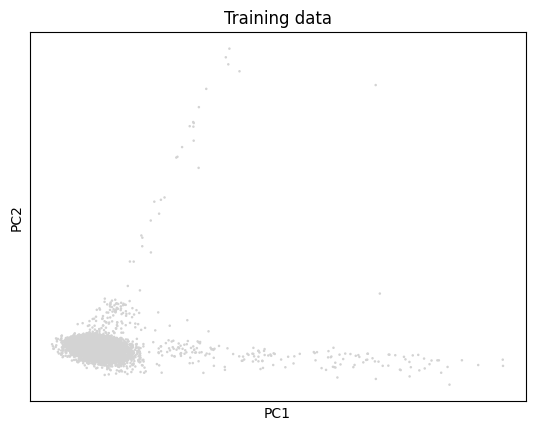

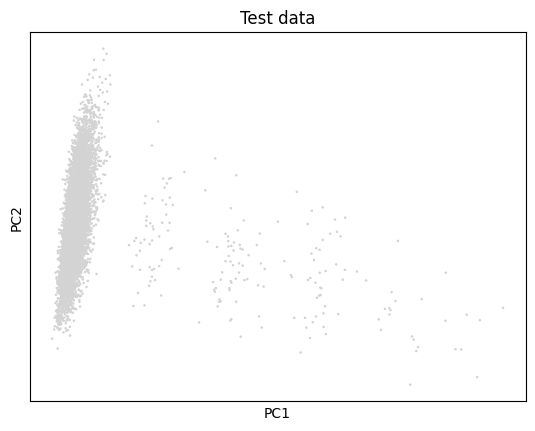

In [21]:
sc.pl.pca(data_train, title="Training data")
plt.show()

sc.pl.pca(data_test, title="Test data")
plt.show()

### Principal component selection

In [22]:
k_errors, k_opt = cs.select_n_pcs_countsplit(data_train, data_test)
print(f"Optimal number of PCs:{k_opt}")

Optimal number of PCs:3


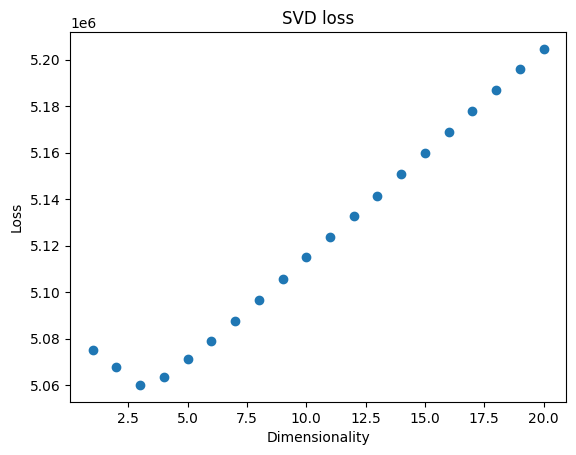

In [23]:
plt.scatter(np.arange(20) + 1, k_errors)
plt.title("SVD loss")
plt.xlabel("Dimensionality")
plt.ylabel("Loss")
plt.show()

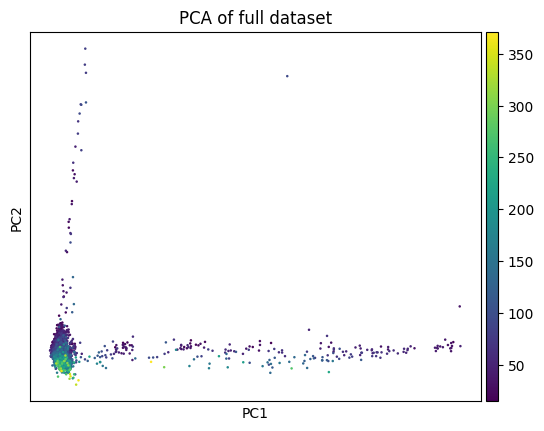

In [24]:
sc.pl.pca(data_gene, color="total_counts", cmap="viridis", title="PCA of full dataset")
plt.show()

In [25]:
data_gene.uns["BacSC_params"] = {"k_opt": k_opt}

## Selection of optimal number of neighbors and optimal UMAP scale via scDEED

In [26]:
rng = np.random.default_rng()
seed = rng.choice(1000)
print(seed)

875


In [27]:
importlib.reload(scd)

n_neighborss = [10, 15, 20, 25, 30, 35, 40, 45, 50, 60, 70, 80, 90, 100, 150, 200, 250]
min_dists = [0.05, 0.1, 0.3, 0.5, 0.7]

scdeed_result, rel_scores, null_rel_scores, reliabilities, n_neighbors_opt, min_dist_opt = scd.scdeed_parameter_selection(data_gene, n_neighborss, min_dists, n_pcs=k_opt, rng_seed=seed, embedding_method="UMAP", similarity_percent=0.5, save_path="Klebs_BIDMC35_scdeed")

calculating (10, 0.05) - run 1/85
calculating (10, 0.1) - run 2/85
calculating (10, 0.3) - run 3/85
calculating (10, 0.5) - run 4/85
calculating (10, 0.7) - run 5/85
calculating (15, 0.05) - run 6/85
calculating (15, 0.1) - run 7/85
calculating (15, 0.3) - run 8/85
calculating (15, 0.5) - run 9/85
calculating (15, 0.7) - run 10/85
calculating (20, 0.05) - run 11/85
calculating (20, 0.1) - run 12/85
calculating (20, 0.3) - run 13/85
calculating (20, 0.5) - run 14/85
calculating (20, 0.7) - run 15/85
calculating (25, 0.05) - run 16/85
calculating (25, 0.1) - run 17/85
calculating (25, 0.3) - run 18/85
calculating (25, 0.5) - run 19/85
calculating (25, 0.7) - run 20/85
calculating (30, 0.05) - run 21/85
calculating (30, 0.1) - run 22/85
calculating (30, 0.3) - run 23/85
calculating (30, 0.5) - run 24/85
calculating (30, 0.7) - run 25/85
calculating (35, 0.05) - run 26/85
calculating (35, 0.1) - run 27/85
calculating (35, 0.3) - run 28/85
calculating (35, 0.5) - run 29/85
calculating (35, 

Optimal number of neighbors: 15
Optimal min_dist: 0.1


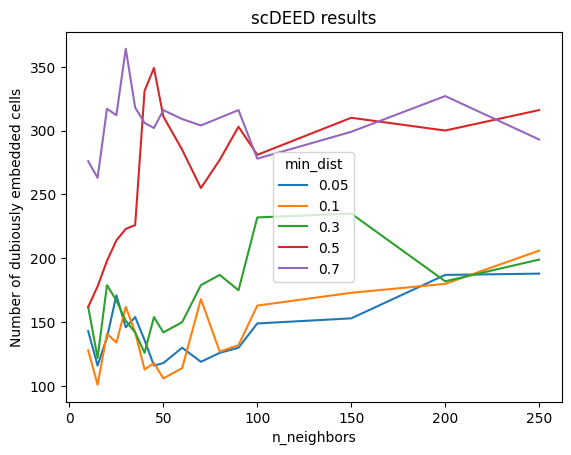

In [28]:
print(f"Optimal number of neighbors: {n_neighbors_opt}")
print(f"Optimal min_dist: {min_dist_opt}")

sns.lineplot(data=scdeed_result, x="n_neighbors", y="num_dubious", hue="min_dist", palette="tab10")
plt.title("scDEED results")
plt.ylabel("Number of dubiously embedded cells")
plt.show()

In [29]:
# k_opt = data_gene.uns["BacSC_params"]["k_opt"]
# n_neighbors_opt = data_gene.uns["BacSC_params"]["n_neighbors_opt"]
# min_dist_opt = data_gene.uns["BacSC_params"]["min_dist_opt"]


# k_opt = 4
# n_neighbors_opt = 30
# min_dist_opt = 0.3
print(k_opt)

3


In [30]:
data_gene.uns["BacSC_params"]["n_neighbors_opt"] = n_neighbors_opt
data_gene.uns["BacSC_params"]["min_dist_opt"] = min_dist_opt

In [31]:
sc.pp.neighbors(data_gene, n_neighbors=n_neighbors_opt, n_pcs=k_opt)
sc.tl.umap(data_gene, neighbors_key="neighbors", min_dist=min_dist_opt, spread=1, random_state=3456)


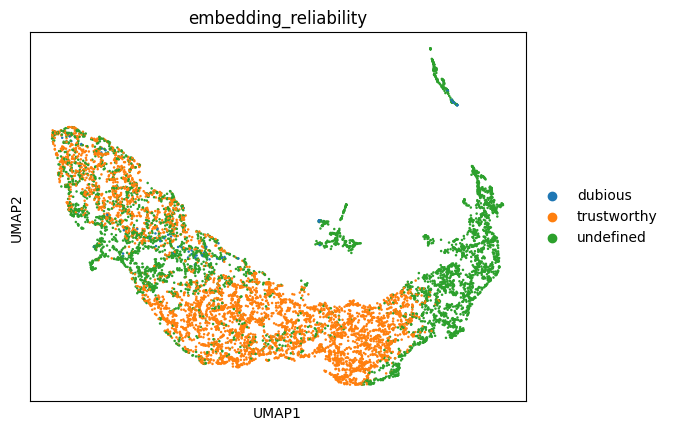

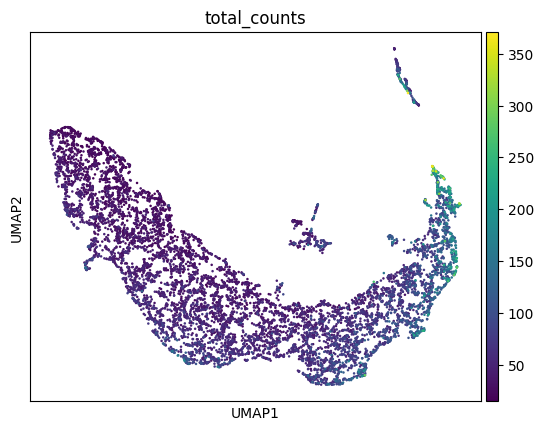

In [32]:
sc.pl.umap(data_gene, color="embedding_reliability", alpha=1)
plt.show()

sc.pl.umap(data_gene, color="total_counts", alpha=1, cmap="viridis")
plt.show()

In [33]:
data_path = "../../data/BacDrop"

data_gene.write(data_path + "/klebsiella_BIDMC35_data_processed_2.h5ad")


## Clustering

### Train/test-split for clustering

In [34]:
sc.pp.neighbors(data_train, n_neighbors=n_neighbors_opt, n_pcs=k_opt)
sc.tl.umap(data_train, neighbors_key="neighbors", min_dist=min_dist_opt, spread=1, random_state=1234)

sc.pp.neighbors(data_test, n_neighbors=n_neighbors_opt, n_pcs=k_opt)
sc.tl.umap(data_test, neighbors_key="neighbors", min_dist=min_dist_opt, spread=1, random_state=1234)


theta_opt, mirror_opt, umap_2_opt, ssd = ut.find_opt_umap_rotation(data_train.obsm["X_umap"].copy(), data_test.obsm["X_umap"].copy())
data_test.obsm["X_umap_rot"] = umap_2_opt

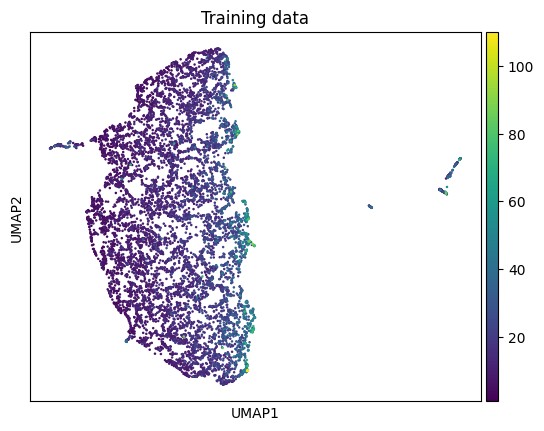

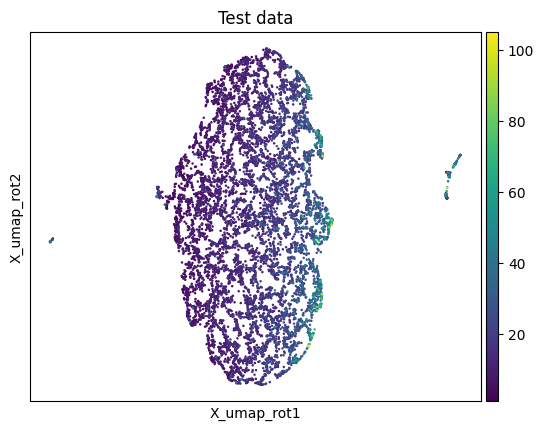

In [35]:
sc.pl.umap(data_train, color="total_counts", cmap="viridis", title="Training data")
plt.show()

sc.pl.embedding(data_test, basis="X_umap_rot", color="total_counts", cmap="viridis", title="Test data")
plt.show()

### Apply clustering with array of resolutions

In [36]:
importlib.reload(co)
res_min = 0.01
res_max = 0.5
res_step = 0.02
resolutions = np.round(np.arange(res_min, res_max, res_step), 2)

co.cluster_train_test(data_train, data_test, resolutions, alg="leiden", random_state=1234)

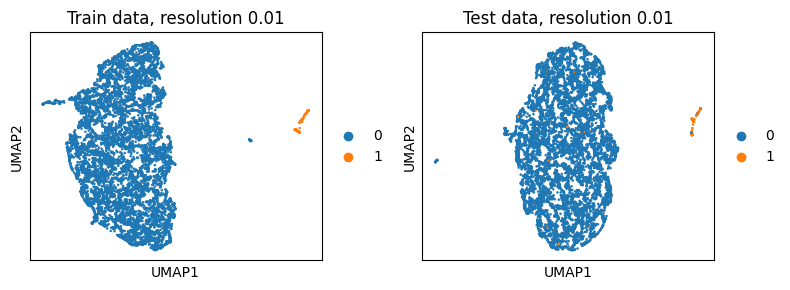

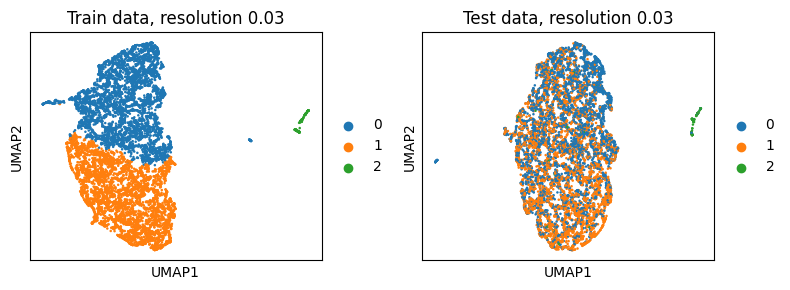

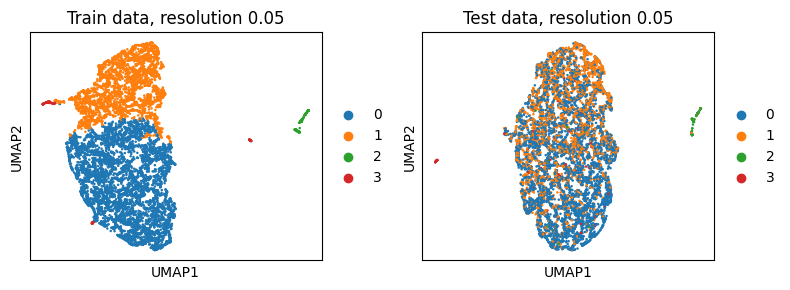

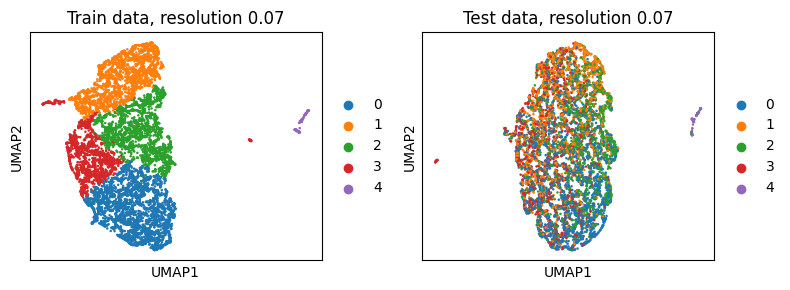

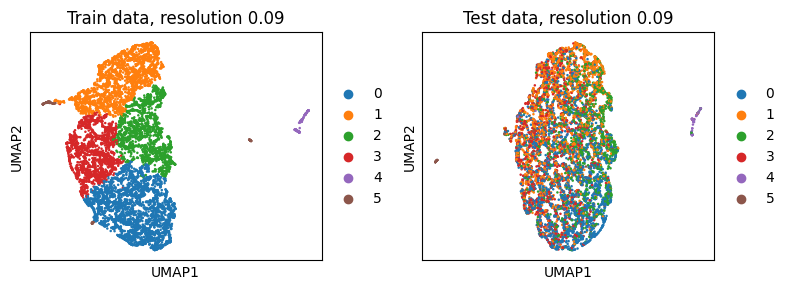

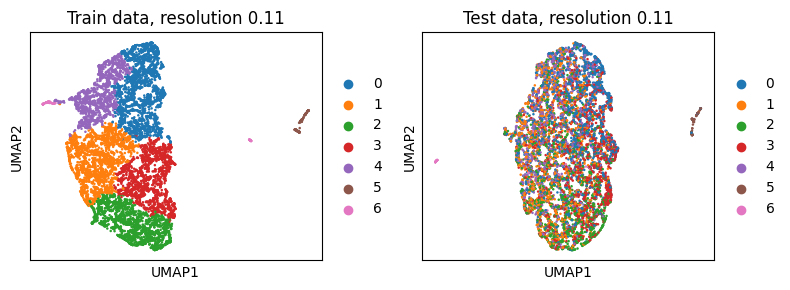

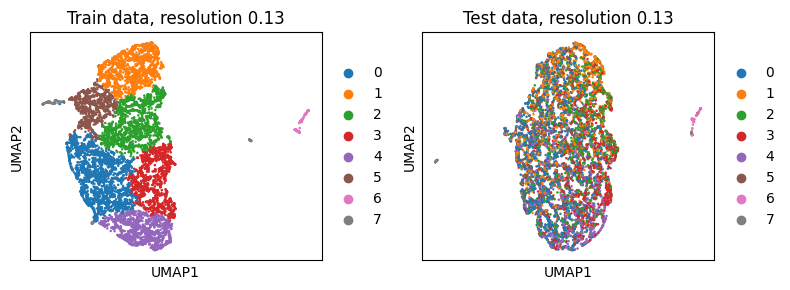

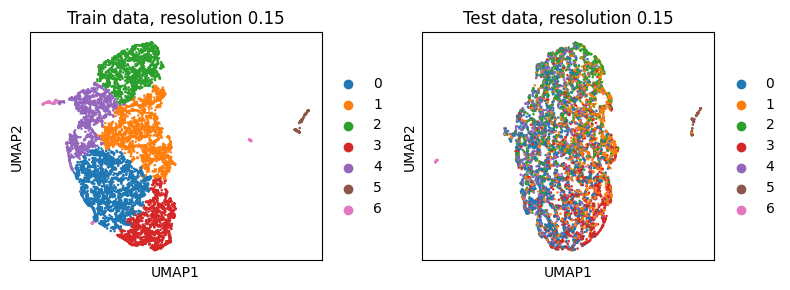

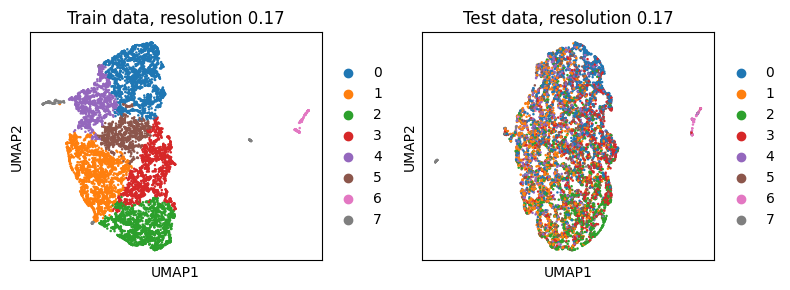

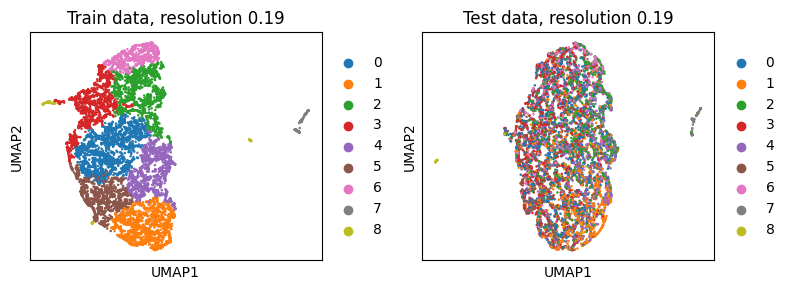

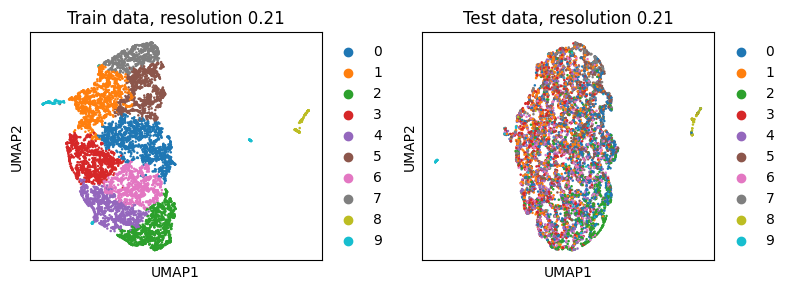

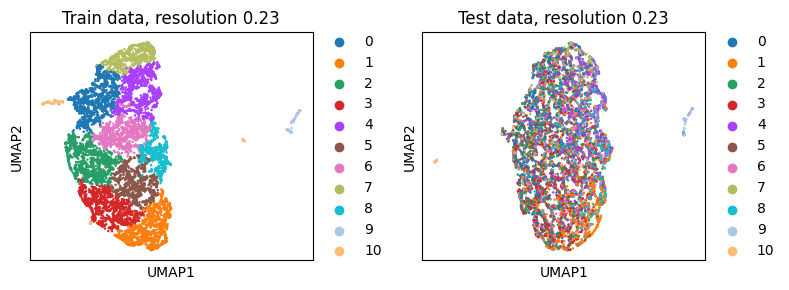

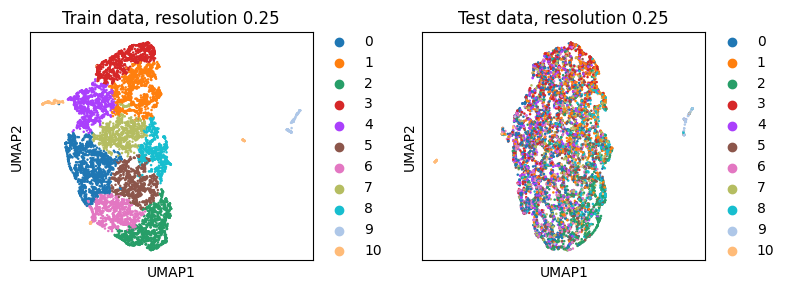

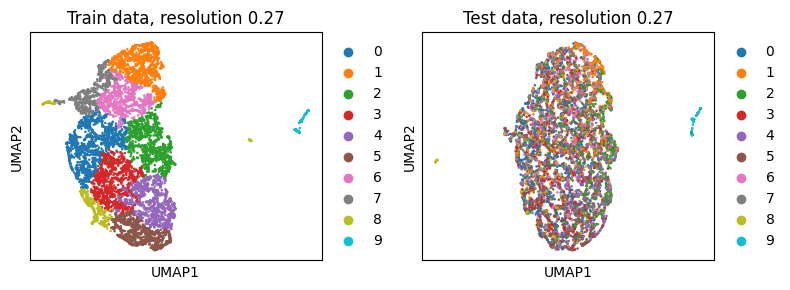

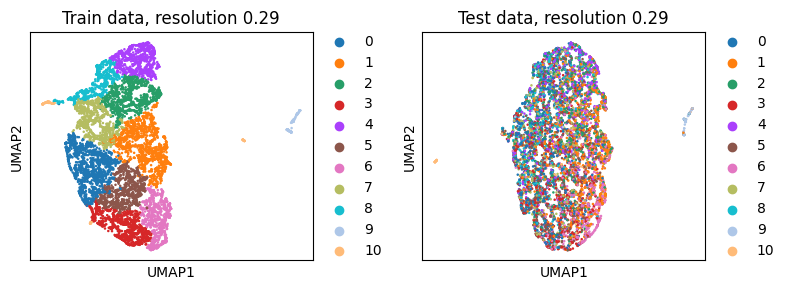

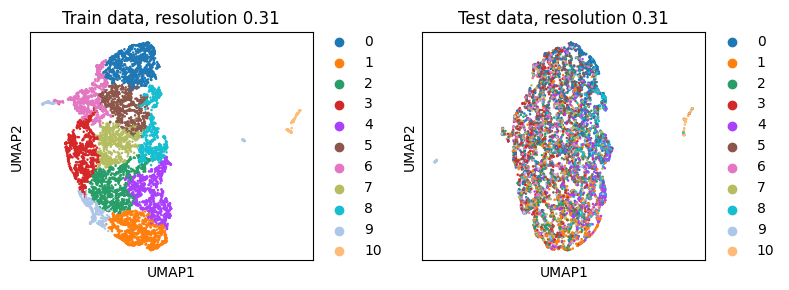

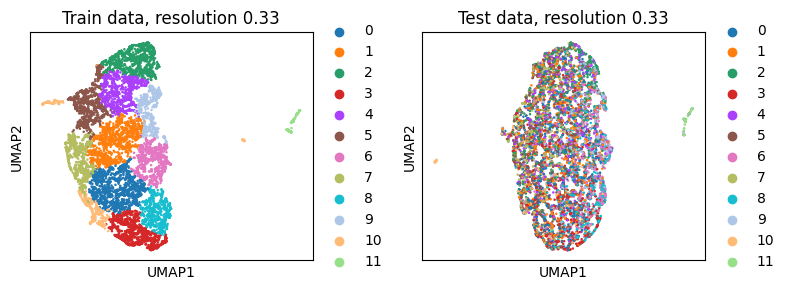

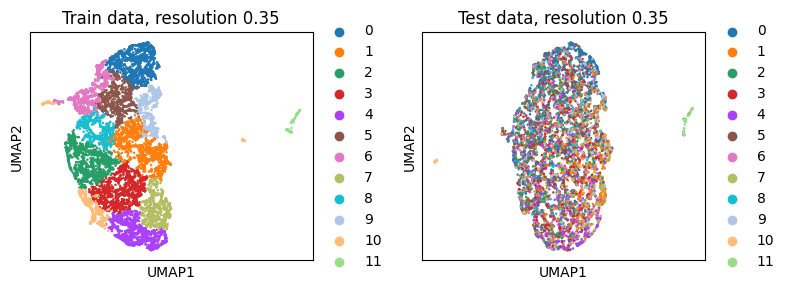

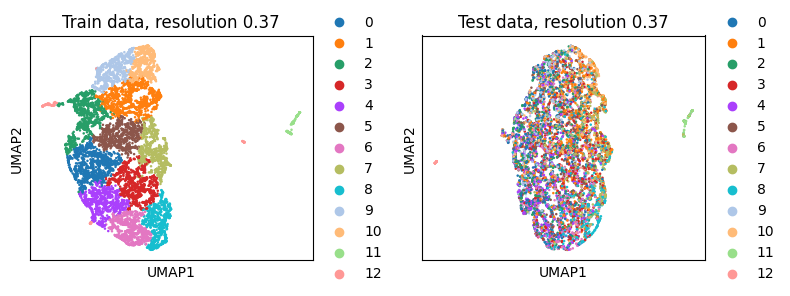

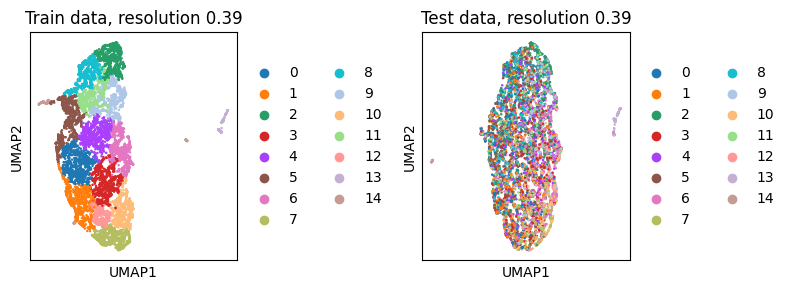

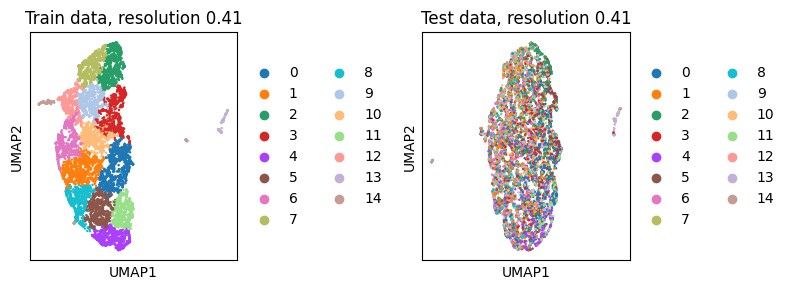

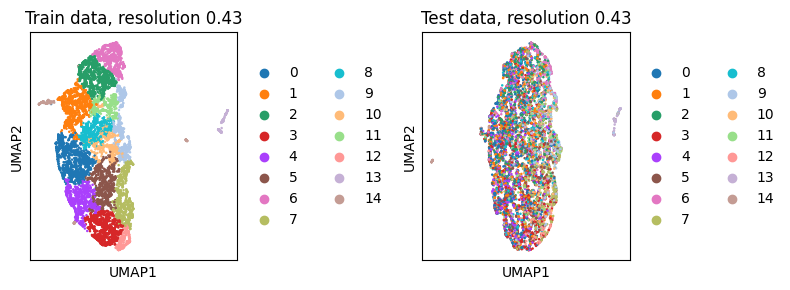

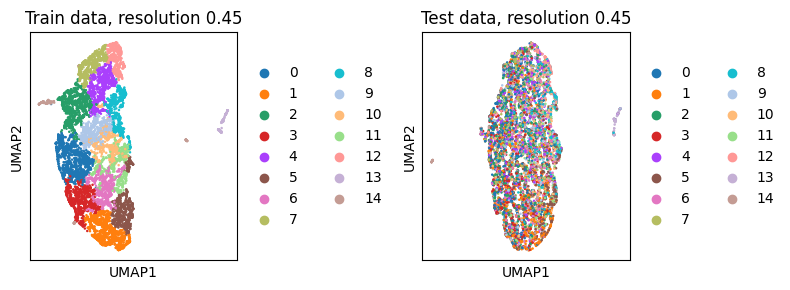

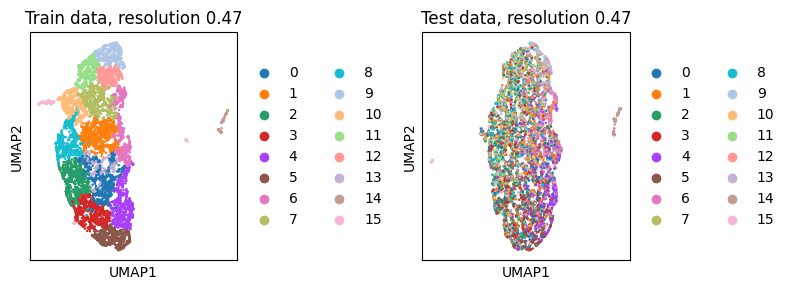

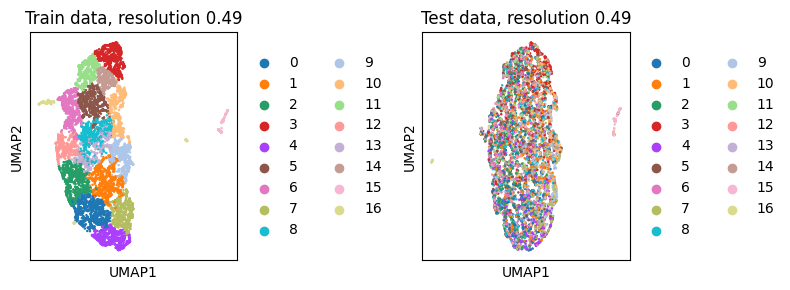

In [37]:
for resolution in resolutions:
    fig, ax = plt.subplots(1, 2, figsize=(8, 3))
    sc.pl.umap(data_train, color=f"leiden_res{resolution}", ax=ax[0], title=f"Train data, resolution {resolution}", show=False)
    sc.pl.embedding(data_test, basis="X_umap_rot", color=f"leiden_res{resolution}", ax=ax[1], title=f"Test data, resolution {resolution}", show=False)
    ax[1].set_xlabel("UMAP1")
    ax[1].set_ylabel("UMAP2")
    plt.tight_layout()
    plt.show()

Modularities

In [38]:
importlib.reload(co)
mod_df, mod_df_wide, res_opt = co.find_optimal_clustering_resolution(data_train, data_test, resolutions, random_seed=1234)

print(f"Optimal resolution {res_opt}")
data_gene.uns["BacSC_params"]["res_opt"] = res_opt


resolution: 0.01 - clusters: 2 - Train: 0.49 - Test: 0.484 - Random: 0.471
resolution: 0.03 - clusters: 3 - Train: 0.478 - Test: 0.27 - Random: 0.225
resolution: 0.05 - clusters: 4 - Train: 0.468 - Test: 0.269 - Random: 0.227
resolution: 0.07 - clusters: 5 - Train: 0.465 - Test: 0.156 - Random: 0.11
resolution: 0.09 - clusters: 6 - Train: 0.46 - Test: 0.152 - Random: 0.103
resolution: 0.11 - clusters: 7 - Train: 0.456 - Test: 0.121 - Random: 0.075
resolution: 0.13 - clusters: 8 - Train: 0.454 - Test: 0.105 - Random: 0.062
resolution: 0.15 - clusters: 7 - Train: 0.449 - Test: 0.115 - Random: 0.068
resolution: 0.17 - clusters: 8 - Train: 0.447 - Test: 0.102 - Random: 0.055
resolution: 0.19 - clusters: 9 - Train: 0.445 - Test: 0.084 - Random: 0.044
resolution: 0.21 - clusters: 10 - Train: 0.443 - Test: 0.072 - Random: 0.036
resolution: 0.23 - clusters: 11 - Train: 0.442 - Test: 0.066 - Random: 0.029
resolution: 0.25 - clusters: 11 - Train: 0.439 - Test: 0.065 - Random: 0.027
resolution: 0

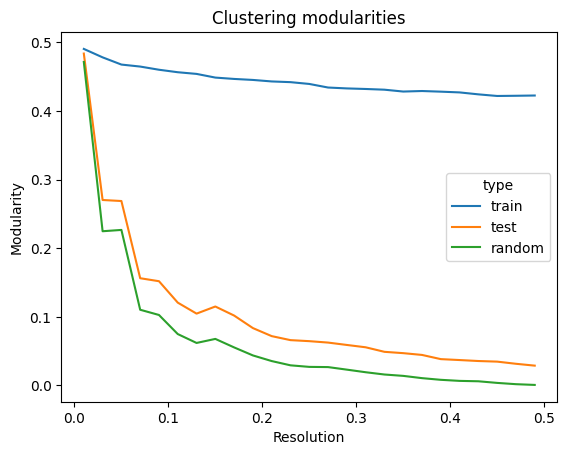

In [39]:
sns.lineplot(data=mod_df, x="resolution", y="score", hue="type")
plt.title("Clustering modularities")
plt.xlabel("Resolution")
plt.ylabel("Modularity")
plt.show()

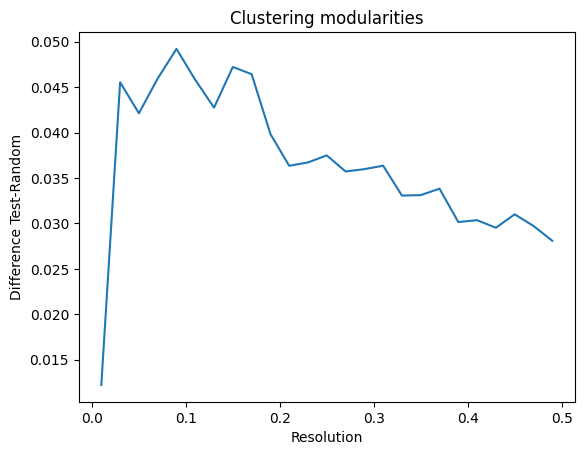

In [40]:
sns.lineplot(data=mod_df_wide, x="resolution", y="diff_rand_test")
plt.title("Clustering modularities")
plt.xlabel("Resolution")
plt.ylabel("Difference Test-Random")
plt.show()

In [41]:
result_path = "Klebs_BIDMC35_clustering"
if not os.path.exists(result_path):
    os.makedirs(result_path)
    
mod_df.to_csv(result_path + "/modularities.csv")
mod_df_wide.to_csv(result_path + "/modularities_wide.csv")

## Cluster analysis

Optimal Leiden resolution: Maximal difference between random and test

In [42]:
sc.tl.leiden(data_gene, resolution=res_opt, key_added="leiden_opt")

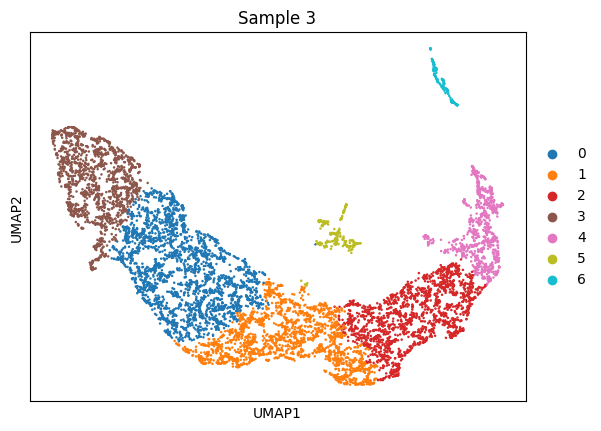

In [43]:
sc.pl.umap(data_gene, color="leiden_opt", palette="tab10", title="Sample 3")
plt.show()

In [44]:
data_gene.write(data_path + "/klebsiella_BIDMC35_data_processed_2.h5ad")

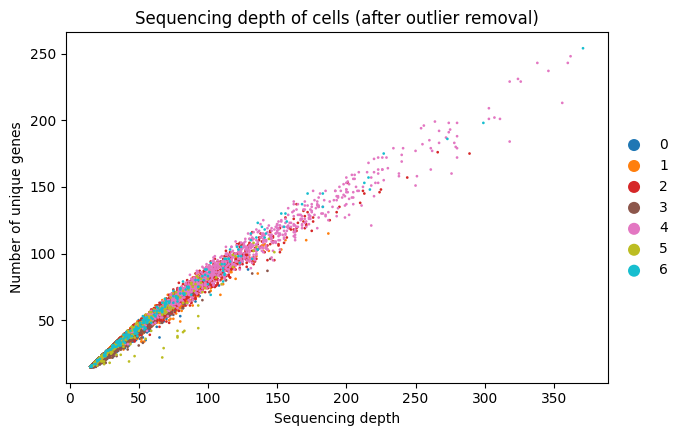

In [45]:
sc.pl.scatter(data_gene, x='total_counts', y='n_genes_by_counts', show=False, size=15, color="leiden_opt")
plt.title("Sequencing depth of cells (after outlier removal)")
plt.xlabel("Sequencing depth")
plt.ylabel("Number of unique genes")
plt.show()

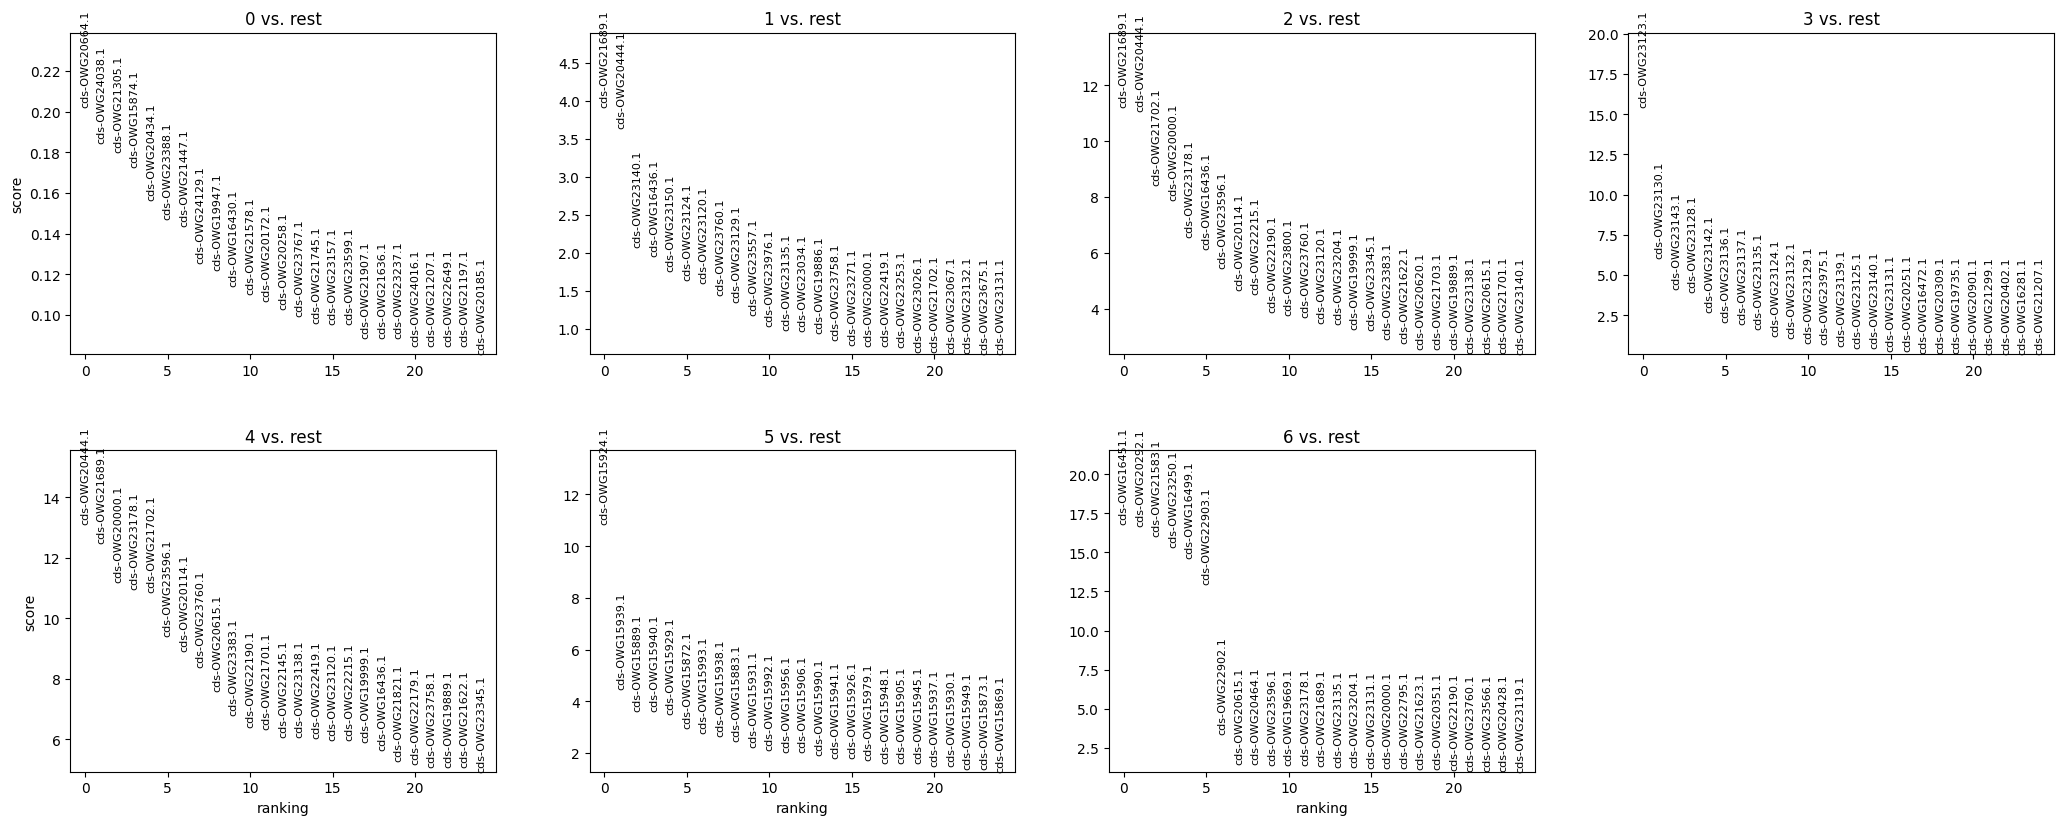

In [46]:
sc.tl.rank_genes_groups(data_gene, 'leiden_opt', method='wilcoxon')
sc.pl.rank_genes_groups(data_gene, n_genes=25, sharey=False)

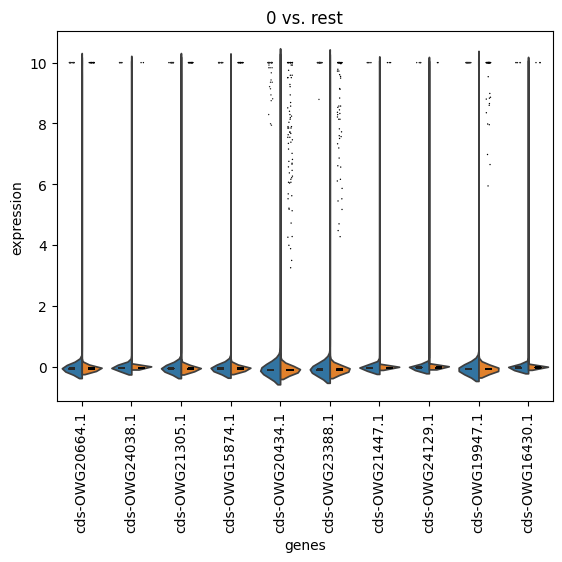

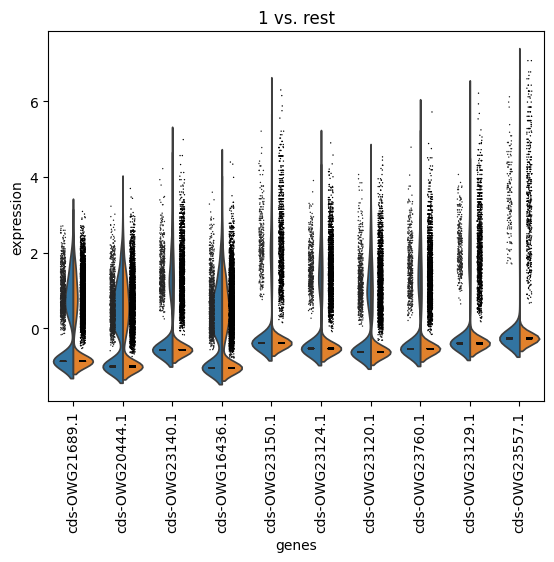

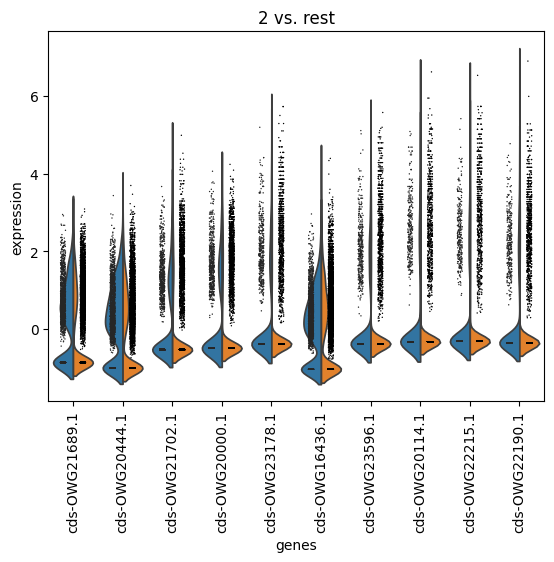

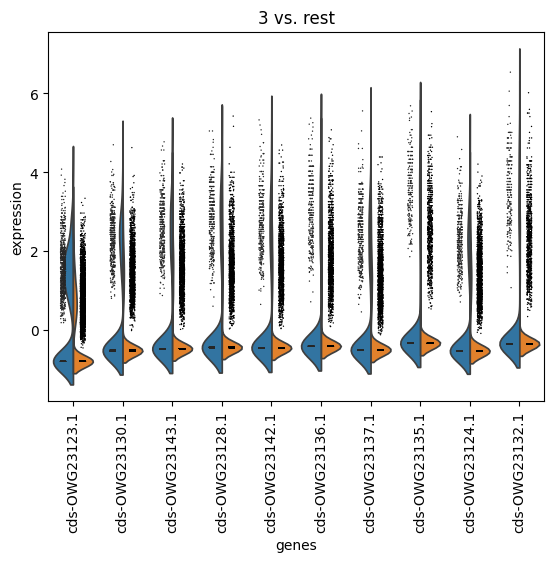

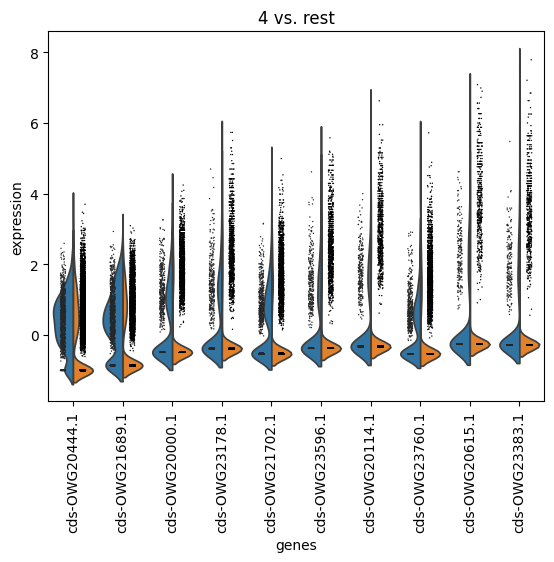

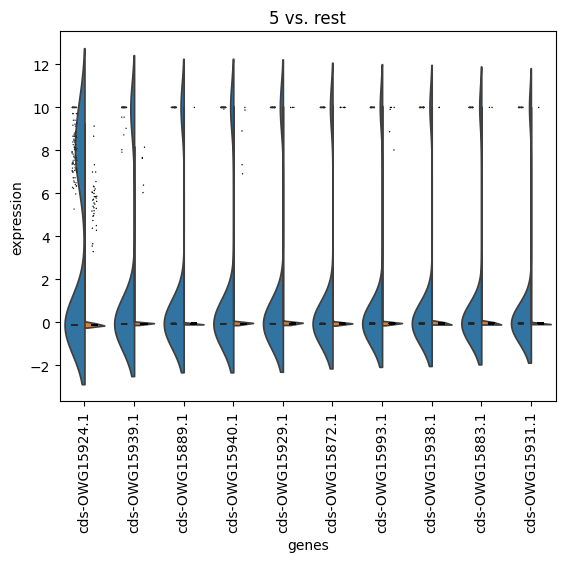

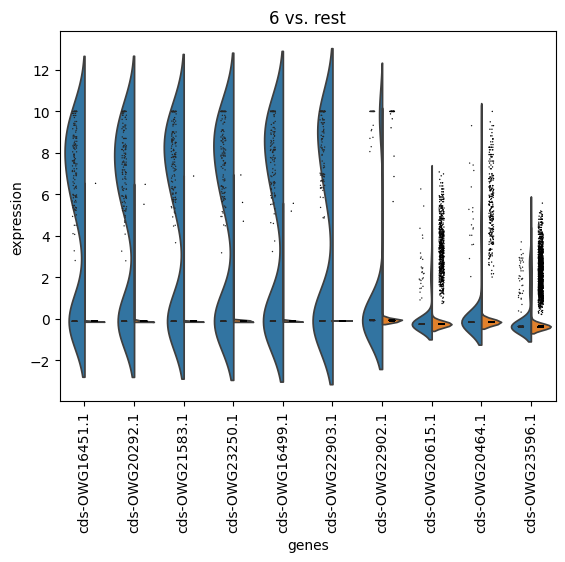

In [47]:
nclust = len(np.unique(data_gene.obs["leiden_opt"]))

for i in range(nclust):
    sc.pl.rank_genes_groups_violin(data_gene, groups=str(i), n_genes=10)

## Attach feature table

In [ ]:
data_path = "../../data/BacDrop/"
data_gene = sc.read_h5ad(data_path + "/klebsiella_BIDMC35_data_processed_2.h5ad")
data_gene

In [ ]:
feature_table = pd.read_csv(data_path + "genomic_information/klebsiella_bidmc35/GCF_000567225.2_ASM56722v2_feature_table.txt", sep="\t")
# feature_table = feature_table[feature_table["# feature"] == "CDS"][["locus_tag", "product_accession", "name", "symbol"]]

feature_table

In [ ]:
ind = data_gene.var.index

data_gene.var["lt"] = [x.removeprefix('cds-') for x in data_gene.var.index]
data_gene.var["lt"] = [re.sub(r"-[0-9]+", "", x) for x in data_gene.var["lt"]]

df3=data_gene.var.reset_index().merge(feature_table, how='left', left_on='lt', right_on='locus_tag', suffixes=(None, "_y")).drop_duplicates("index").set_index("index")
df4=data_gene.var.reset_index().merge(feature_table, how='left', left_on='lt', right_on='product_accession', suffixes=(None, "_y")).drop_duplicates("index").set_index("index")
df5 = pd.merge(df3, df4, how="outer", left_index=True, right_index=True, suffixes=(None, "_y"))

df5.locus_tag.fillna(df5.locus_tag_y, inplace=True)
df5.product_accession.fillna(df5.product_accession_y, inplace=True)
df5.name.fillna(df5.name_y, inplace=True)
df5.symbol.fillna(df5.symbol_y, inplace=True)

df5 = df5.loc[:,~df5.columns.str.endswith('_y')]

mdf = data_gene.var.merge(df5, how="left", left_index=True, right_index=True, suffixes=(None, "_y"))
mdf = mdf.loc[:,~mdf.columns.str.endswith('_y')]
data_gene.var
data_gene.var = mdf

In [ ]:
sc.tl.rank_genes_groups(data_gene, 'leiden_opt', method='wilcoxon')
sc.pl.rank_genes_groups(data_gene, n_genes=25, sharey=False)

In [ ]:
top_genes = [x[0] for x in data_gene.uns["rank_genes_groups"]["names"]]
print(data_gene.var.loc[top_genes[:25], :])


In [ ]:
data_gene.var

In [ ]:
# data_gene.write(data_path + "/klebsiella_BIDMC35_data_processed_2.h5ad")